## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import pickle
from copy import deepcopy
from math import sqrt, ceil
import datetime
import sys
from itertools import product
import pandas as pd
import json
import hyperopt

from data_utils import load_cfar10_batch, load_label_names
from losses import CategoricalHingeLoss, CategoricalCrossEntropyLoss
from activations import LinearActivation, ReLUActivation, SoftmaxActivation
from initializers import NormalInitializer, XavierInitializer
from layers import Dense, BatchNormalization
from regularizers import L2Regularizer
from models import Model
from metrics import AccuracyMetrics
from optimizers import SGDOptimizer
from lr_schedules import LRConstantSchedule, LRExponentialDecaySchedule, LRCyclingSchedule
from grad_check import eval_numerical_gradient, eval_numerical_gradient_array, numerical_gradient_check_model

## Load data and prepare the training, the validation, and the test set

In [7]:
# Load data
# train and val set are batch 1, 2, 3, 4, and 5, test set is test
path = os.path.join("data", "data_batch_1")
x_train_img_1, y_train_1 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_2")
x_train_img_2, y_train_2 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_3")
x_train_img_3, y_train_3 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_4")
x_train_img_4, y_train_4 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_5")
x_train_img_5, y_train_5 = load_cfar10_batch(path)

x_train_val_img = np.vstack([x_train_img_1, x_train_img_2, x_train_img_3, x_train_img_4, x_train_img_5])
y_train_val = np.hstack([y_train_1, y_train_2, y_train_3, y_train_4, y_train_5])

x_train_img, x_val_img, y_train, y_val = train_test_split(x_train_val_img, y_train_val,
                                                          test_size=0.1, random_state=42)

path = os.path.join("data", "test_batch")
x_test_img, y_test = load_cfar10_batch(path)

# check counts in datasets
print(f"train set shape: {x_train_img.shape}, "
      f"val set shape: {x_val_img.shape}, test set shape: {x_test_img.shape}")
print(f"train labels shape: {y_train.shape},"
      f" val labels shape: {y_val.shape}, test labels shape: {y_test.shape}")

# assert balanced dataset
train_counts = np.unique(y_train, return_counts=True)[1]
train_ratios = train_counts / train_counts.sum()

val_counts = np.unique(y_val, return_counts=True)[1]
val_ratios = val_counts / val_counts.sum()

test_counts = np.unique(y_test, return_counts=True)[1]
test_ratios = test_counts / test_counts.sum()

# np.testing.assert_array_equal(train_ratios, val_ratios)
# np.testing.assert_array_equal(val_ratios, test_ratios)

#np.testing.assert_allclose(train_ratios, val_ratios, rtol=1e-1, atol=0)
#np.testing.assert_allclose(val_ratios, test_ratios, rtol=1e-1, atol=0)

# Pre-process data
x_train_un = x_train_img.reshape(x_train_img.shape[0], -1)
x_val_un = x_val_img.reshape(x_val_img.shape[0], -1)
x_test_un = x_test_img.reshape(x_test_img.shape[0], -1)

x_train = x_train_un / 255.
x_val = x_val_un / 255.
x_test = x_test_un / 255.

mean = np.mean(x_train, axis=0).reshape(1, x_train.shape[1])
std = np.std(x_train, axis=0).reshape(1, x_train.shape[1])

x_train = (x_train - mean) / std
x_val = (x_val - mean) / std
x_test = (x_test - mean) / std

train set shape: (45000, 32, 32, 3), val set shape: (5000, 32, 32, 3), test set shape: (10000, 32, 32, 3)
train labels shape: (45000,), val labels shape: (5000,), test labels shape: (10000,)


## Grad check

In [ ]:
def build_model_2_layer_with_loss_cross_entropy(reg_rate, in_dim, seed):
    
    params = {"coeff": 1.0, "mean": 0.0, "std": None}
    out_dim = 10
    mid_dim = 50

    if reg_rate != 0.0:
        kernel_regularizer = L2Regularizer(reg_rate)
    else:
        kernel_regularizer = None

    dense_1 = \
        Dense(in_dim=in_dim, out_dim=mid_dim,
              kernel_initializer=XavierInitializer(seed=seed, **params),
              bias_initializer=XavierInitializer(seed=seed + 1, **params),
              kernel_regularizer=kernel_regularizer,
              activation=ReLUActivation()
              )
    
    dense_2 = \
        Dense(in_dim=mid_dim, out_dim=out_dim,
              kernel_initializer=XavierInitializer(seed=seed + 2, **params),
              bias_initializer=XavierInitializer(seed=seed + 3, **params),
              kernel_regularizer=kernel_regularizer,
              activation=SoftmaxActivation()
              )

    layers = [
        dense_1,
        dense_2
    ]

    model = Model(layers)
    loss = CategoricalCrossEntropyLoss()

    return model, loss

def build_model_3_layer_with_loss_cross_entropy(reg_rate, in_dim, seed):
    
    params = {"coeff": 1.0, "mean": 0.0, "std": None}
    mid_dim_1 = 50
    mid_dim_2 = 50
    out_dim = 10

    if reg_rate != 0.0:
        kernel_regularizer = L2Regularizer(reg_rate)
    else:
        kernel_regularizer = None

    dense_1 = \
        Dense(in_dim=in_dim, out_dim=mid_dim_1,
              kernel_initializer=XavierInitializer(seed=seed, **params),
              bias_initializer=XavierInitializer(seed=seed + 1, **params),
              kernel_regularizer=kernel_regularizer,
              activation=ReLUActivation()
              )
    
    dense_2 = \
        Dense(in_dim=mid_dim_1, out_dim=mid_dim_2,
              kernel_initializer=XavierInitializer(seed=seed + 2, **params),
              bias_initializer=XavierInitializer(seed=seed + 3, **params),
              kernel_regularizer=kernel_regularizer,
              activation=ReLUActivation()
              )
    
    dense_3 = \
        Dense(in_dim=mid_dim_2, out_dim=out_dim,
              kernel_initializer=XavierInitializer(seed=seed + 4, **params),
              bias_initializer=XavierInitializer(seed=seed + 5, **params),
              kernel_regularizer=kernel_regularizer,
              activation=SoftmaxActivation()
              )

    layers = [
        dense_1,
        dense_2,
        dense_3
    ]

    model = Model(layers)
    loss = CategoricalCrossEntropyLoss()
    
    return model, loss


def build_model_2_layer_with_bn_with_loss_cross_entropy(reg_rate, in_dim, seed):
    
    params = {"coeff": 1.0, "mean": 0.0, "std": None}
    out_dim = 10
    mid_dim = 50

    if reg_rate != 0.0:
        kernel_regularizer = L2Regularizer(reg_rate)
    else:
        kernel_regularizer = None

    dense_1 = \
        Dense(in_dim=in_dim, out_dim=mid_dim,
              kernel_initializer=XavierInitializer(seed=seed, **params),
              bias_initializer=XavierInitializer(seed=seed + 1, **params),
              kernel_regularizer=kernel_regularizer,
              activation=ReLUActivation()
              )
    
    bn_1 = BatchNormalization(momentum=0.9, epsilon=1e-5)
    
    dense_2 = \
        Dense(in_dim=mid_dim, out_dim=out_dim,
              kernel_initializer=XavierInitializer(seed=seed + 2, **params),
              bias_initializer=XavierInitializer(seed=seed + 3, **params),
              kernel_regularizer=kernel_regularizer,
              activation=SoftmaxActivation()
              )

    layers = [
        dense_1,
        bn_1,
        dense_2
    ]

    model = Model(layers)
    loss = CategoricalCrossEntropyLoss()

    return model, loss

def build_model_3_layer_with_bn_with_loss_cross_entropy(reg_rate, in_dim, seed):
    
    params = {"coeff": 1.0, "mean": 0.0, "std": None}
    mid_dim_1 = 50
    mid_dim_2 = 50
    out_dim = 10

    if reg_rate != 0.0:
        kernel_regularizer = L2Regularizer(reg_rate)
    else:
        kernel_regularizer = None

    dense_1 = \
        Dense(in_dim=in_dim, out_dim=mid_dim_1,
              kernel_initializer=XavierInitializer(seed=seed, **params),
              bias_initializer=XavierInitializer(seed=seed + 1, **params),
              kernel_regularizer=kernel_regularizer,
              activation=ReLUActivation()
              )
    
    bn_1 = BatchNormalization(momentum=0.9, epsilon=1e-5)
    
    dense_2 = \
        Dense(in_dim=mid_dim_1, out_dim=mid_dim_2,
              kernel_initializer=XavierInitializer(seed=seed + 2, **params),
              bias_initializer=XavierInitializer(seed=seed + 3, **params),
              kernel_regularizer=kernel_regularizer,
              activation=ReLUActivation()
              )
    
    bn_2 = BatchNormalization(momentum=0.9, epsilon=1e-5)
    
    dense_3 = \
        Dense(in_dim=mid_dim_2, out_dim=out_dim,
              kernel_initializer=XavierInitializer(seed=seed + 4, **params),
              bias_initializer=XavierInitializer(seed=seed + 5, **params),
              kernel_regularizer=kernel_regularizer,
              activation=SoftmaxActivation()
              )

    layers = [
        dense_1,
        bn_1,
        dense_2,
        bn_2,
        dense_3
    ]

    model = Model(layers)
    loss = CategoricalCrossEntropyLoss()
    
    return model, loss


def test_model(x, y, seed=6):
    size = (2, 20)
    c = 10
    np.random.seed(seed + 1)
    x = np.random.normal(loc=0, scale=1, size=size)
    np.random.seed(seed + 2)
    y = np.random.randint(c, size=size[0])

    in_dim = x.shape[1]

    build_model_loss_func_list = [
        build_model_2_layer_with_loss_cross_entropy,
        build_model_3_layer_with_loss_cross_entropy,
        build_model_2_layer_with_bn_with_loss_cross_entropy,
        build_model_3_layer_with_bn_with_loss_cross_entropy
    ]

    np.random.seed(seed + 3)
    reg_rates = 10e-1 * np.random.randint(low=1, high=10, size=5)

    for reg_rate in reg_rates:
        for build_model_func in build_model_loss_func_list:
            model, loss = build_model_func(reg_rate, in_dim, seed)
            numerical_gradient_check_model(x, y, model, loss)
            
test_model(x_train[:2, :10], y_train[:2])

## Helpers

In [11]:
def plot_losses(history, filename):
    plt.plot(history["loss_train"], label="train")
    plt.plot(history["loss_val"], label="val")
    plt.grid()
    plt.title("Loss vs. epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    path = f"{filename}_losses.png"
    plt.savefig(path)
    plt.show()
    
def plot_costs(history, filename):
    plt.plot(history["cost_train"], label="train")
    plt.plot(history["cost_val"], label="val")
    plt.grid()
    plt.title("Cost vs. epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.legend()
    path = f"{filename}_costs.png"
    plt.savefig(path)
    plt.show()
    
def plot_accuracies(history, filename):
    plt.plot(history["accuracy_train"], label="train")
    plt.plot(history["accuracy_val"], label="val")
    plt.grid()
    plt.title("Accuracy vs. epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    path = f"{filename}_accuracies.png"
    plt.savefig(path)
    plt.show()
    
def plot_lr(history, filename):
    plt.plot(history["lr"], label="lr")
    plt.grid()
    plt.title("Learning rate vs. epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Learning rate")
    plt.legend()
    path = f"{filename}_lrs.png"
    plt.savefig(path)
    plt.show()

## Calcuate stuff for the cycling LR schedule

In [ ]:
batch_size = 100

print(x_train.shape[0])
n_s = int(5 * x_train.shape[0] / batch_size)
print(f"step size of cyc. lr: {n_s} update steps")

cycle_steps = 2*n_s
print(f"full cycle of cyc.lr : {cycle_steps} update steps")

#print(cycle * batch_size)

epochs_one_full_cycle = (cycle_steps * batch_size) / x_train.shape[0]
print(f"{epochs_one_full_cycle} epochs = 1 full cycle = {cycle_steps} update steps")

n_cycle = 2
print(f"{n_cycle} cycle = {n_cycle*epochs_one_full_cycle} epochs = {n_cycle*cycle_steps} update steps")

## 3 Layer

### Without BN

In [ ]:
seed = 10

params = {"coeff": 1.0, "mean": 0.0, "std": None}

in_dim = x_train.shape[1]
mid_dim_1 = 50
mid_dim_2 = 50
out_dim = 10

reg_rate = 0.005

dense_1 = \
    Dense(in_dim=in_dim, out_dim=mid_dim_1,
          kernel_initializer=XavierInitializer(seed=seed, **params),
          bias_initializer=XavierInitializer(seed=seed + 1, **params),
          kernel_regularizer=L2Regularizer(reg_rate),
          activation=ReLUActivation()
          )

dense_2 = \
    Dense(in_dim=mid_dim_1, out_dim=mid_dim_2,
          kernel_initializer=XavierInitializer(seed=seed + 2, **params),
          bias_initializer=XavierInitializer(seed=seed + 3, **params),
          kernel_regularizer=L2Regularizer(reg_rate),
          activation=ReLUActivation()
          )

dense_3 = \
    Dense(in_dim=mid_dim_2, out_dim=out_dim,
          kernel_initializer=XavierInitializer(seed=seed + 4, **params),
          bias_initializer=XavierInitializer(seed=seed + 5, **params),
          kernel_regularizer=L2Regularizer(reg_rate),
          activation=SoftmaxActivation()
          )

layers = [
    dense_1,
    dense_2,
    dense_3
]

model = Model(layers)
loss = CategoricalCrossEntropyLoss()

lr_initial = 1e-5
lr_max = 1e-1
step_size = 2250
lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)

optimizer = SGDOptimizer(lr_schedule=lr_schedule)

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
print(model)

batch_size = 100
n_epochs = 20
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)

params_test = {"mode": "test"}
scores_test = model.forward(x_test, **params_test)
y_hat_test = np.argmax(scores_test, axis=1)
metrics_test = model.compute_metrics(y_test, scores_test)

filename = "3_layer_no_bn_xavier_init"
plot_losses(history, filename)
plot_costs(history, filename)
plot_accuracies(history, filename)
plot_lr(history, filename)

print(f"test acc: {metrics_test}")

## With BN

In [ ]:
seed = 10

params = {"coeff": 1.0, "mean": 0.0, "std": None}

in_dim = x_train.shape[1]
mid_dim_1 = 50
mid_dim_2 = 50
out_dim = 10

reg_rate = 0.005

dense_1 = \
    Dense(in_dim=in_dim, out_dim=mid_dim_1,
          kernel_initializer=XavierInitializer(seed=seed, **params),
          bias_initializer=XavierInitializer(seed=seed + 1, **params),
          kernel_regularizer=L2Regularizer(reg_rate),
          activation=ReLUActivation()
          )
bn_1 = BatchNormalization(momentum=0.9, epsilon=1e-5) 

dense_2 = \
    Dense(in_dim=mid_dim_1, out_dim=mid_dim_2,
          kernel_initializer=XavierInitializer(seed=seed + 2, **params),
          bias_initializer=XavierInitializer(seed=seed + 3, **params),
          kernel_regularizer=L2Regularizer(reg_rate),
          activation=ReLUActivation()
          )

bn_2 = BatchNormalization(momentum=0.9, epsilon=1e-5)

dense_3 = \
    Dense(in_dim=mid_dim_2, out_dim=out_dim,
          kernel_initializer=XavierInitializer(seed=seed + 4, **params),
          bias_initializer=XavierInitializer(seed=seed + 5, **params),
          kernel_regularizer=L2Regularizer(reg_rate),
          activation=SoftmaxActivation()
          )

layers = [
    dense_1,
    bn_1,
    dense_2,
    bn_2,
    dense_3
]

model = Model(layers)
loss = CategoricalCrossEntropyLoss()

lr_initial = 1e-5
lr_max = 1e-1
step_size = 2250
lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)

optimizer = SGDOptimizer(lr_schedule=lr_schedule)

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
print(model)

batch_size = 100
n_epochs = 20
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)

params_test = {"mode": "test"}
scores_test = model.forward(x_test, **params_test)
y_hat_test = np.argmax(scores_test, axis=1)
metrics_test = model.compute_metrics(y_test, scores_test)

filename = "3_layer_with_bn_xavier_init"
plot_losses(history, filename)
plot_costs(history, filename)
plot_accuracies(history, filename)
plot_lr(history, filename)

print(f"test acc: {metrics_test}")

## 9 Layer

### Without BN

In [ ]:
seed = 10

params = {"coeff": 1.0, "mean": 0.0, "std": None}

in_dim = x_train.shape[1]
out_dim = 10

reg_rate = 0.005

dims = [50, 30, 20, 20, 10, 10, 10, 10]

dims = list(reversed(list(reversed(dims)) + [in_dim])) + [out_dim]

layers = []


for n_layer in range(1, len(dims)):
    #print(n_layer)
    #print(dims[n_layer])
    if n_layer == len(dims)-1:
        dense = \
            Dense(in_dim=dims[n_layer-1], out_dim=dims[n_layer],
                  kernel_initializer=XavierInitializer(seed=seed + n_layer, **params),
                  bias_initializer=XavierInitializer(seed=seed + n_layer, **params),
                  kernel_regularizer=L2Regularizer(reg_rate),
                  activation=SoftmaxActivation()
                  )
    else:
        dense = \
            Dense(in_dim=dims[n_layer-1], out_dim=dims[n_layer],
                  kernel_initializer=XavierInitializer(seed=seed + n_layer, **params),
                  bias_initializer=XavierInitializer(seed=seed + n_layer, **params),
                  kernel_regularizer=L2Regularizer(reg_rate),
                  activation=ReLUActivation()
                  )
        
    layers.append(dense)

model = Model(layers)
loss = CategoricalCrossEntropyLoss()

lr_initial = 1e-5
lr_max = 1e-1
step_size = 2250
lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)

optimizer = SGDOptimizer(lr_schedule=lr_schedule)

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
print(model)

batch_size = 100
n_epochs = 20
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)

params_test = {"mode": "test"}
scores_test = model.forward(x_test, **params_test)
y_hat_test = np.argmax(scores_test, axis=1)
metrics_test = model.compute_metrics(y_test, scores_test)

filename = "9_layer_no_bn_xavier_init"
plot_losses(history, filename)
plot_costs(history, filename)
plot_accuracies(history, filename)
plot_lr(history, filename)

print(f"test acc: {metrics_test}")

### With BN

In [ ]:
seed = 12

params = {"coeff": 1.0, "mean": 0.0, "std": None}

in_dim = x_train.shape[1]
out_dim = 10

reg_rate = 0.005

dims = [50, 30, 20, 20, 10, 10, 10, 10]

dims = list(reversed(list(reversed(dims)) + [in_dim])) + [out_dim]

layers = []


for n_layer in range(1, len(dims)):
    #print(n_layer)
    #print(dims[n_layer])
    if n_layer == len(dims)-1:
        dense = \
            Dense(in_dim=dims[n_layer-1], out_dim=dims[n_layer],
                  kernel_initializer=XavierInitializer(seed=seed + n_layer, **params),
                  bias_initializer=XavierInitializer(seed=seed + n_layer, **params),
                  kernel_regularizer=L2Regularizer(reg_rate),
                  activation=SoftmaxActivation()
                  )
    else:
        dense = \
            Dense(in_dim=dims[n_layer-1], out_dim=dims[n_layer],
                  kernel_initializer=XavierInitializer(seed=seed + n_layer, **params),
                  bias_initializer=XavierInitializer(seed=seed + n_layer, **params),
                  kernel_regularizer=L2Regularizer(reg_rate),
                  activation=ReLUActivation()
                  )
        bn = BatchNormalization(momentum=0.9, epsilon=1e-5)
        
        
    layers.append(dense)
    
    if n_layer == len(dims)-1:
        pass
    else:
        layers.append(bn)

model = Model(layers)
loss = CategoricalCrossEntropyLoss()

lr_initial = 1e-5
lr_max = 1e-1
step_size = 2250
lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)

optimizer = SGDOptimizer(lr_schedule=lr_schedule)

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
print(f"len(layers) = {len(layers)}")
print(model)

batch_size = 100
n_epochs = 20
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)

params_test = {"mode": "test"}
scores_test = model.forward(x_test, **params_test)
y_hat_test = np.argmax(scores_test, axis=1)
metrics_test = model.compute_metrics(y_test, scores_test)

filename = "9_layer_with_bn_xavier_init"
plot_losses(history, filename)
plot_costs(history, filename)
plot_accuracies(history, filename)
plot_lr(history, filename)

print(f"test acc: {metrics_test}")

## Hyperparam search for reg_rate

In [ ]:
class Tuner():
    def __init__(self, build_model, objective, iterations=1, **params):
        # objective is of Metrics for now
        self.build_model = build_model
        self.objective = objective
        self.iterations = iterations
        self.params = params
        self.params_product = list(product(*params.values()))
        self.params_names = list(params.keys())
    
    def search(self, x_train, y_train, x_val, y_val, n_epochs, batch_size):
        # list of tuples = list(product([1,2,3],[3,4]))
        # for tuple in list:
        # rows in final df
        rows = []
        
        #params_product = tqdm(self.params_product, file=sys.stdout)
        
        n_prod = len(self.params_product)
        
        for idx_prod, prod in enumerate(self.params_product):
            
            params = {}
            for idx, param_name in enumerate(self.params_names):
                params[param_name] = prod[idx]
            #print(params)
            #print(n_prod)
            
            # if more than 1 iterations
            objective_list = []
            
            for it in range(self.iterations):
                print("*"*5)
                print(f"tuner: {idx_prod+1}/{n_prod} config (iter: {it+1}/{self.iterations})")
                # build_model with tuple params
                model = build_model(seed=200, **params)
                # fit model
                history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)
                # meaasure objective on model
                params_test = {"mode": "test"}
                scores_val = model.forward(x_val, **params_test)
                objective_val = self.objective.compute(y_val, scores_val)
                # save objective in list
                objective_list.append(objective_val)
                
            # average objective in list
            objective_mean = np.array(objective_list).mean()
            # save tuple of params and objective as dict
            objective_dict = {self.objective.name: objective_mean}
            row_dict = {**params, **objective_dict}
            rows.append(row_dict)
            print("*"*5 + "\n")
            
        # df from list of dicts of params and objective val
        df = pd.DataFrame(data=rows)
        
        # save to csv
        date_string = datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S:%f")
        path = os.path.join("tuner_results", date_string + ".csv")
        
        df.to_csv(path, encoding='utf-8', index=False)
        
        # argmax across rows and return best params as dict (~**params)
        best_params = dict(df.loc[df[self.objective.name].idxmax()])
        best_objective = best_params.pop(self.objective.name)
        
        return best_objective, best_params

In [ ]:
def build_model_func(seed=200, **params):
    
    assert "reg_rate_l2" in params.keys()
    reg_rate_l2 = params["reg_rate_l2"]

    params = {"coeff": 1.0, "mean": 0.0, "std": None}

    in_dim = x_train.shape[1]
    mid_dim_1 = 50
    mid_dim_2 = 50
    out_dim = 10

    #reg_rate = 0.005

    dense_1 = \
        Dense(in_dim=in_dim, out_dim=mid_dim_1,
              kernel_initializer=XavierInitializer(seed=seed, **params),
              bias_initializer=XavierInitializer(seed=seed + 1, **params),
              kernel_regularizer=L2Regularizer(reg_rate_l2),
              activation=ReLUActivation()
              )
    bn_1 = BatchNormalization(momentum=0.9, epsilon=1e-5) 

    dense_2 = \
        Dense(in_dim=mid_dim_1, out_dim=mid_dim_2,
              kernel_initializer=XavierInitializer(seed=seed + 2, **params),
              bias_initializer=XavierInitializer(seed=seed + 3, **params),
              kernel_regularizer=L2Regularizer(reg_rate_l2),
              activation=ReLUActivation()
              )

    bn_2 = BatchNormalization(momentum=0.9, epsilon=1e-5)

    dense_3 = \
        Dense(in_dim=mid_dim_2, out_dim=out_dim,
              kernel_initializer=XavierInitializer(seed=seed + 4, **params),
              bias_initializer=XavierInitializer(seed=seed + 5, **params),
              kernel_regularizer=L2Regularizer(reg_rate_l2),
              activation=SoftmaxActivation()
              )

    layers = [
        dense_1,
        bn_1,
        dense_2,
        bn_2,
        dense_3
    ]

    model = Model(layers)
    loss = CategoricalCrossEntropyLoss()

    lr_initial = 1e-5
    lr_max = 1e-1
    step_size = 2250
    lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)

    optimizer = SGDOptimizer(lr_schedule=lr_schedule)

    metrics = [AccuracyMetrics()]

    model.compile_model(optimizer, loss, metrics)
    print(model)
    
    return model

In [ ]:
def coarse_custom(n):
    l_min = -5
    l_max = -1
    #np.random.seed(seed)
    
    return [10 **(l_min + (l_max - l_min) * np.random.uniform(low=0, high=1)) for i in range(n)]

def coarse_to_fine_custom(best_via_coarse, n):
    half_interval = 0.4
    low = best_via_coarse * (1-half_interval) 
    high = best_via_coarse * (1+half_interval)
    
    return [np.random.uniform(low=low, high=high) for i in range(n)] 

In [ ]:
def coarse_to_fine_loop(best_params, best_objective, coarse_to_fine_custom, build_model, objective,
                        x_train, y_train, x_val, y_val, n_epochs, batch_size, n, n_levels=3):
    
    winner_params = deepcopy(best_params)
    winner_objective = deepcopy(best_objective)
    
    for n_level in range(n_levels):
        print("-"*10)
        print(f"level {n_level+1}/{n_levels}")
        #n = 10
        #batch_size = 100
        #n_epochs = 20

        params = {"reg_rate_l2": coarse_to_fine_custom(best_params["reg_rate_l2"], n=n)}
        tuner = Tuner(build_model, objective, iterations=1, **params)
        best_objective, best_params = tuner.search(x_train, y_train, x_val, y_val, n_epochs, batch_size)
        
        if winner_objective < best_objective:
            winner_params = deepcopy(best_params)
            winner_objective = deepcopy(best_objective)
        
        print("-"*10)
        print(f"level {n_level+1}/{n_levels}")
        print(f"best obj:{winner_objective:.4f}, with {winner_params}")
        print("-"*10)
        
    return winner_objective, winner_params

In [ ]:
objective = AccuracyMetrics()
build_model = build_model_func

# coarse
n = 5
batch_size = 100
n_epochs = 20

params = {"reg_rate_l2": coarse_to_fine_custom(0.005, n)}
tuner = Tuner(build_model, objective, iterations=1, **params)
best_objective, best_params = tuner.search(x_train, y_train, x_val, y_val, n_epochs, batch_size)

print(f"best obj:{best_objective:.4f}, with {best_params}")

# coarse to fine
best_objective, best_params = \
    coarse_to_fine_loop(best_params, best_objective, coarse_to_fine_custom, build_model, objective, 
                        x_train, y_train, x_val, y_val, n_epochs, batch_size, n, n_levels=2)

print(f"best obj:{best_objective:.4f}, with {best_params}")

### training with the best reg_rate for 3 cycles

In [ ]:
model = build_model_func(seed=200, **best_params)
batch_size = 100
n_epochs = 30
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)

params_test = {"mode": "test"}
scores_test = model.forward(x_test, **params_test)
y_hat_test = np.argmax(scores_test, axis=1)
metrics_test = model.compute_metrics(y_test, scores_test)

filename = "3_layer_with_bn_xavier_init_best_l2"
plot_losses(history, filename)
plot_costs(history, filename)
plot_accuracies(history, filename)
plot_lr(history, filename)

print(f"test acc: {metrics_test}")

## Sensitivity to initialization

In [8]:
def network_bn_sigma(dims, if_bn, sigma):
    #filename = f"9_layer_with_bn_normal_init_sigma_{sigma}"
    seed = 10

    params = {"coeff": 1.0, "mean": 0.0, "std": sigma}

    reg_rate = 0.005

    layers = []


    for n_layer in range(1, len(dims)):
        #print(n_layer)
        #print(dims[n_layer])
        if n_layer == len(dims)-1:
            dense = \
                Dense(in_dim=dims[n_layer-1], out_dim=dims[n_layer],
                      kernel_initializer=NormalInitializer(seed=seed + n_layer, **params),
                      bias_initializer=NormalInitializer(seed=seed + n_layer, **params),
                      kernel_regularizer=L2Regularizer(reg_rate),
                      activation=SoftmaxActivation()
                      )
        else:
            dense = \
                Dense(in_dim=dims[n_layer-1], out_dim=dims[n_layer],
                      kernel_initializer=NormalInitializer(seed=seed + n_layer, **params),
                      bias_initializer=NormalInitializer(seed=seed + n_layer, **params),
                      kernel_regularizer=L2Regularizer(reg_rate),
                      activation=ReLUActivation()
                      )
            if if_bn:
                bn = BatchNormalization(momentum=0.9, epsilon=1e-5)


        layers.append(dense)

        if n_layer == len(dims)-1:
            pass
        else:
            if if_bn:
                layers.append(bn)

    model = Model(layers)
    loss = CategoricalCrossEntropyLoss()

    lr_initial = 1e-5
    lr_max = 1e-1
    step_size = 2250
    lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)

    optimizer = SGDOptimizer(lr_schedule=lr_schedule)

    metrics = [AccuracyMetrics()]

    model.compile_model(optimizer, loss, metrics)
    print(f"len(layers) = {len(layers)}")
    print(model)
    
    return model

len(layers) = 3
model summary: 
layer 0: dense: 
	 shape -- in: 3072, out: 50
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2)
	 activation: relu

layer 1: dense: 
	 shape -- in: 50, out: 50
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2)
	 activation: relu

layer 2: dense: 
	 shape -- in: 50, out: 10
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2)
	 activation: softmax

categorical cross-entropy loss
sgd with cycling lr schedule

starting epoch: 1 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 79.33it/s]
epoch 1/20 
 	 -- train loss = 1.9077970549619818 / train cost = 5.639213242888903
	 -- {"accuracy_train": 0.31453333333333333} 
	 -- val loss = 1.946876748802995 / val cost = 5.678292936729916
	 -- {"accur

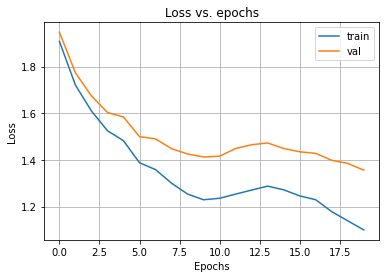

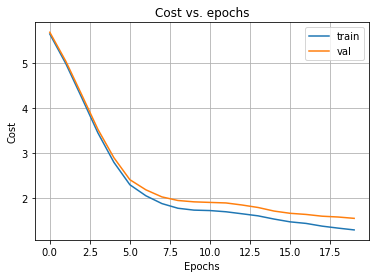

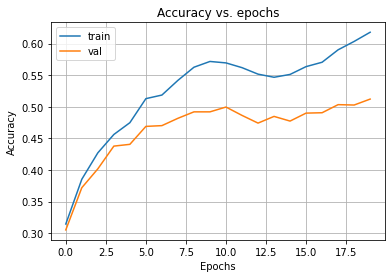

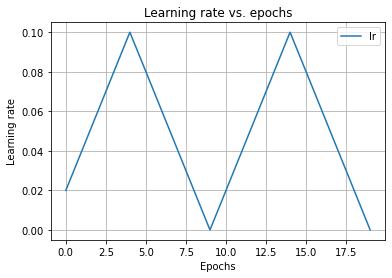

test acc: {'accuracy': 0.5346}
len(layers) = 3
model summary: 
layer 0: dense: 
	 shape -- in: 3072, out: 50
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2)
	 activation: relu

layer 1: dense: 
	 shape -- in: 50, out: 50
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2)
	 activation: relu

layer 2: dense: 
	 shape -- in: 50, out: 10
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2)
	 activation: softmax

categorical cross-entropy loss
sgd with cycling lr schedule

starting epoch: 1 ...
batch 450/450: 100%|██████████| 450/450 [00:06<00:00, 73.24it/s]
epoch 1/20 
 	 -- train loss = 2.3025932224562684 / train cost = 2.3029666804876197
	 -- {"accuracy_train": 0.10031111111111111} 
	 -- val loss = 2.3026145477800446 / val cost

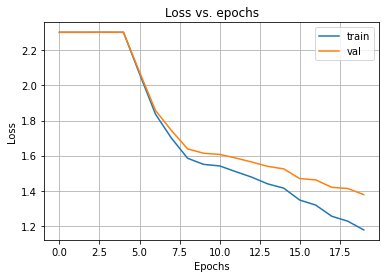

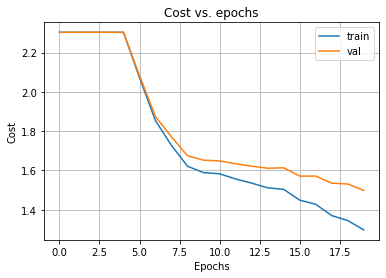

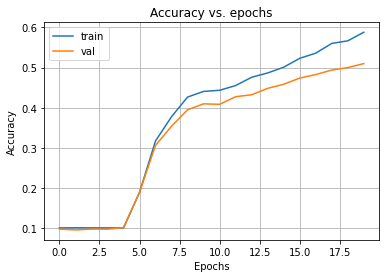

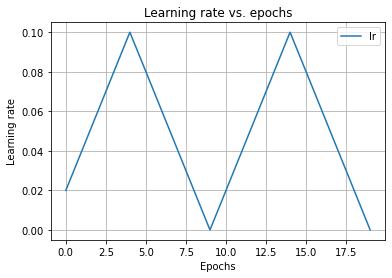

test acc: {'accuracy': 0.5193}
len(layers) = 3
model summary: 
layer 0: dense: 
	 shape -- in: 3072, out: 50
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2)
	 activation: relu

layer 1: dense: 
	 shape -- in: 50, out: 50
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2)
	 activation: relu

layer 2: dense: 
	 shape -- in: 50, out: 10
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2)
	 activation: softmax

categorical cross-entropy loss
sgd with cycling lr schedule

starting epoch: 1 ...
batch 450/450: 100%|██████████| 450/450 [00:04<00:00, 97.11it/s] 
epoch 1/20 
 	 -- train loss = 2.302593270204016 / train cost = 2.30259700467607
	 -- {"accuracy_train": 0.10031111111111111} 
	 -- val loss = 2.3026135313337845 / val cost =

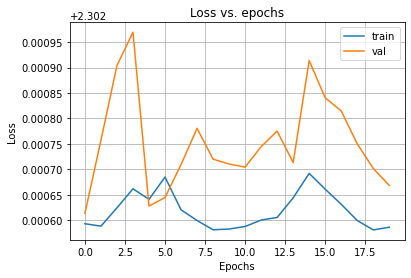

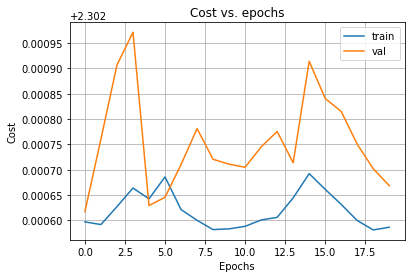

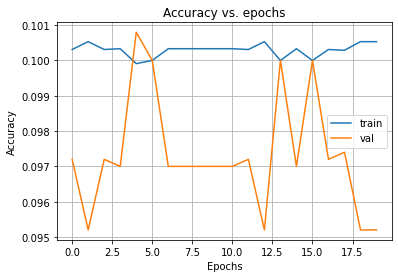

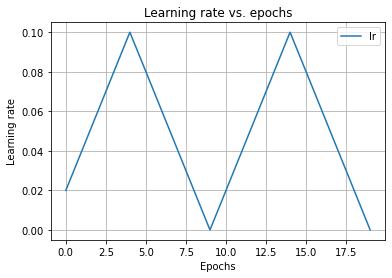

test acc: {'accuracy': 0.1}
len(layers) = 5
model summary: 
layer 0: dense: 
	 shape -- in: 3072, out: 50
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2)
	 activation: relu

layer 1: batch norm with momentum 0.9
layer 2: dense: 
	 shape -- in: 50, out: 50
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2)
	 activation: relu

layer 3: batch norm with momentum 0.9
layer 4: dense: 
	 shape -- in: 50, out: 10
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2)
	 activation: softmax

categorical cross-entropy loss
sgd with cycling lr schedule

starting epoch: 1 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 89.09it/s]
epoch 1/20 
 	 -- train loss = 1.9202961880867928 / train cost = 5.654622263682395
	 -- {"accuracy_tra

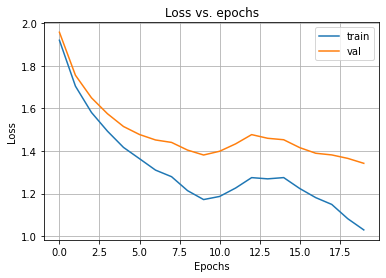

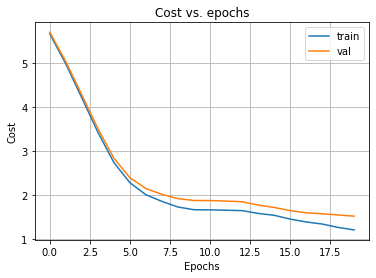

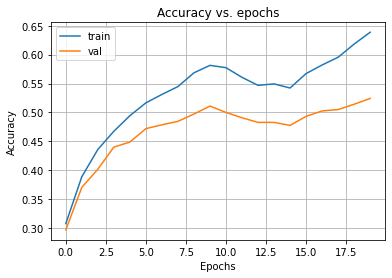

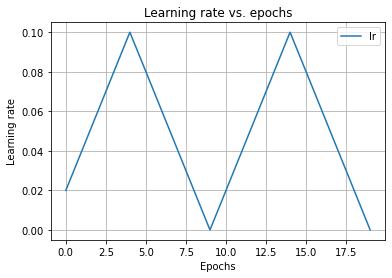

test acc: {'accuracy': 0.536}
len(layers) = 5
model summary: 
layer 0: dense: 
	 shape -- in: 3072, out: 50
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2)
	 activation: relu

layer 1: batch norm with momentum 0.9
layer 2: dense: 
	 shape -- in: 50, out: 50
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2)
	 activation: relu

layer 3: batch norm with momentum 0.9
layer 4: dense: 
	 shape -- in: 50, out: 10
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2)
	 activation: softmax

categorical cross-entropy loss
sgd with cycling lr schedule

starting epoch: 1 ...
batch 450/450: 100%|██████████| 450/450 [00:04<00:00, 90.38it/s]
epoch 1/20 
 	 -- train loss = 1.6590429010575982 / train cost = 1.6654420933843046
	 -- {"accuracy_

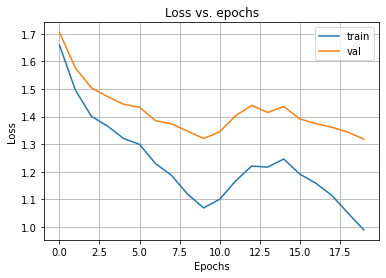

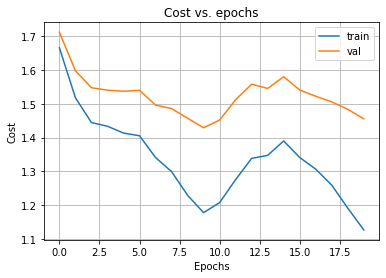

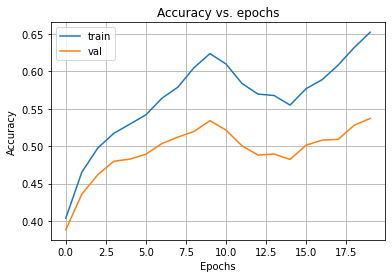

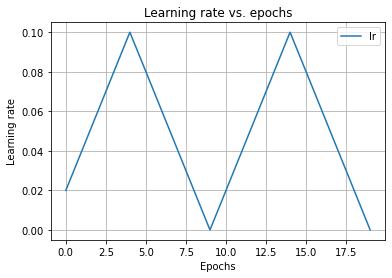

test acc: {'accuracy': 0.5346}
len(layers) = 5
model summary: 
layer 0: dense: 
	 shape -- in: 3072, out: 50
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2)
	 activation: relu

layer 1: batch norm with momentum 0.9
layer 2: dense: 
	 shape -- in: 50, out: 50
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2)
	 activation: relu

layer 3: batch norm with momentum 0.9
layer 4: dense: 
	 shape -- in: 50, out: 10
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2)
	 activation: softmax

categorical cross-entropy loss
sgd with cycling lr schedule

starting epoch: 1 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 89.15it/s]
epoch 1/20 
 	 -- train loss = 1.7129676716397921 / train cost = 1.7182208350814672
	 -- {"accuracy

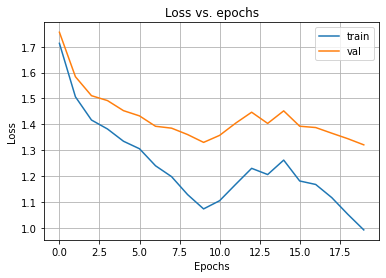

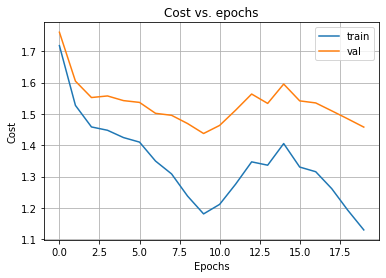

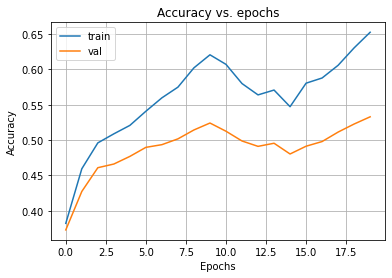

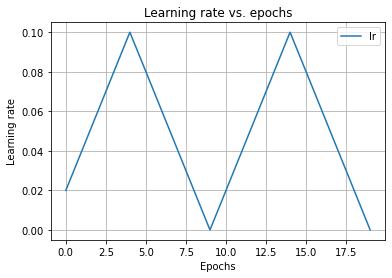

test acc: {'accuracy': 0.535}
len(layers) = 9
model summary: 
layer 0: dense: 
	 shape -- in: 3072, out: 50
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2)
	 activation: relu

layer 1: dense: 
	 shape -- in: 50, out: 30
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2)
	 activation: relu

layer 2: dense: 
	 shape -- in: 30, out: 20
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2)
	 activation: relu

layer 3: dense: 
	 shape -- in: 20, out: 20
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2)
	 activation: relu

layer 4: dense: 
	 shape -- in: 20, out: 10
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2), reg: l2 with 5.0000e-0

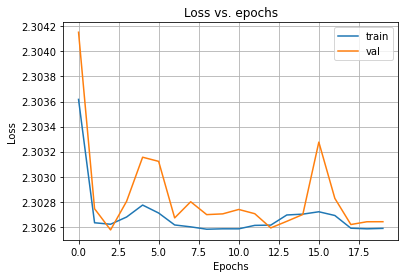

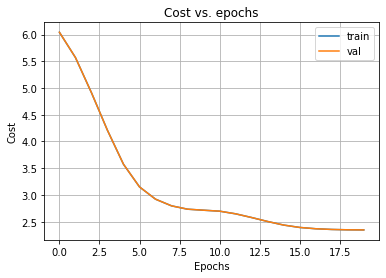

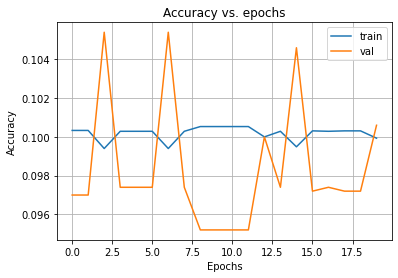

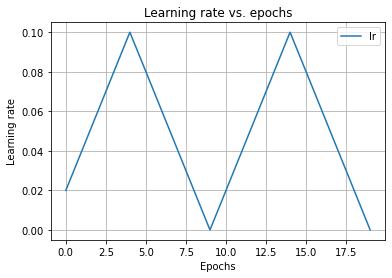

test acc: {'accuracy': 0.1}
len(layers) = 9
model summary: 
layer 0: dense: 
	 shape -- in: 3072, out: 50
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2)
	 activation: relu

layer 1: dense: 
	 shape -- in: 50, out: 30
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2)
	 activation: relu

layer 2: dense: 
	 shape -- in: 30, out: 20
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2)
	 activation: relu

layer 3: dense: 
	 shape -- in: 20, out: 20
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2)
	 activation: relu

layer 4: dense: 
	 shape -- in: 20, out: 10
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2), reg: l2 with 5.0000e-03


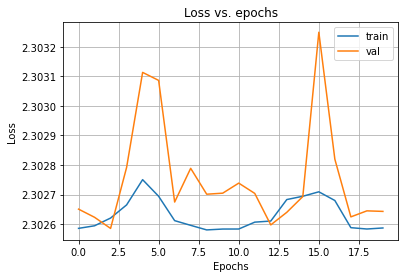

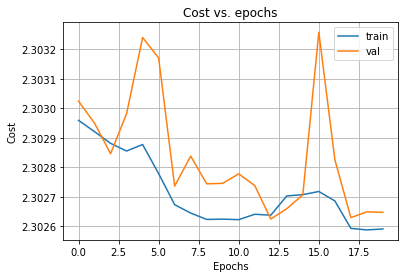

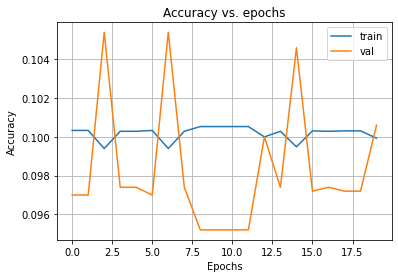

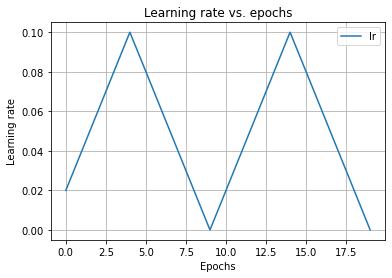

test acc: {'accuracy': 0.1}
len(layers) = 9
model summary: 
layer 0: dense: 
	 shape -- in: 3072, out: 50
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2)
	 activation: relu

layer 1: dense: 
	 shape -- in: 50, out: 30
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2)
	 activation: relu

layer 2: dense: 
	 shape -- in: 30, out: 20
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2)
	 activation: relu

layer 3: dense: 
	 shape -- in: 20, out: 20
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2)
	 activation: relu

layer 4: dense: 
	 shape -- in: 20, out: 10
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2), reg: l2 with 5.0000e-03


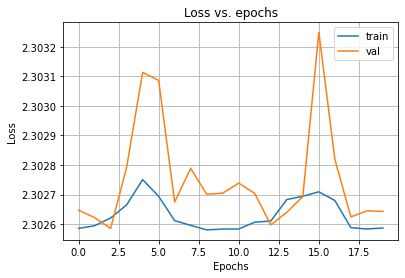

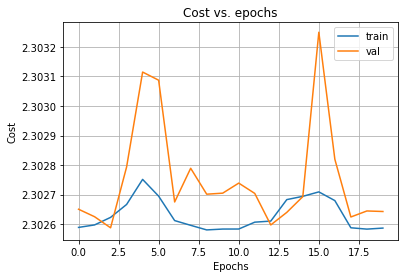

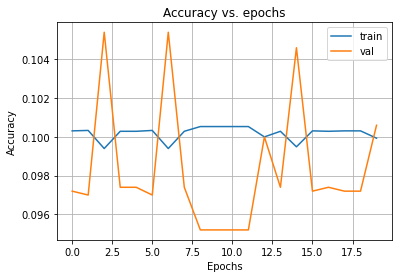

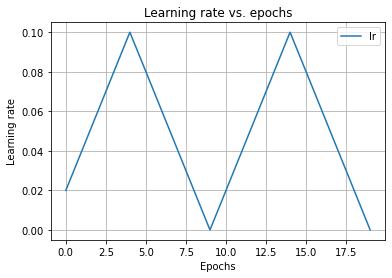

test acc: {'accuracy': 0.1}
len(layers) = 17
model summary: 
layer 0: dense: 
	 shape -- in: 3072, out: 50
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2)
	 activation: relu

layer 1: batch norm with momentum 0.9
layer 2: dense: 
	 shape -- in: 50, out: 30
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2)
	 activation: relu

layer 3: batch norm with momentum 0.9
layer 4: dense: 
	 shape -- in: 30, out: 20
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2)
	 activation: relu

layer 5: batch norm with momentum 0.9
layer 6: dense: 
	 shape -- in: 20, out: 20
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.100000^2)
	 activation: relu

layer 7: ba

batch 450/450: 100%|██████████| 450/450 [00:08<00:00, 53.94it/s]
epoch 20/20 
 	 -- train loss = 1.1184298238595172 / train cost = 1.292841286114162
	 -- {"accuracy_train": 0.6030666666666666} 
	 -- val loss = 1.3639132120173787 / val cost = 1.5383246742720236
	 -- {"accuracy_val": 0.512} 




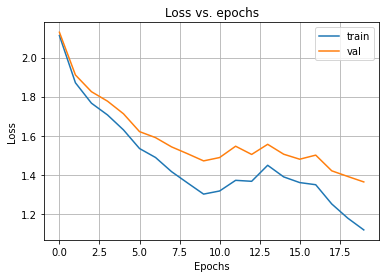

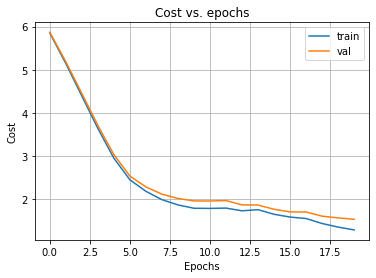

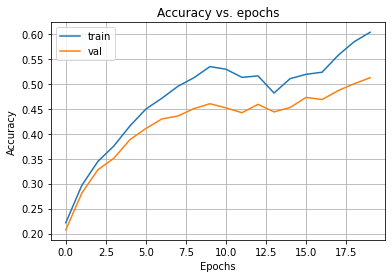

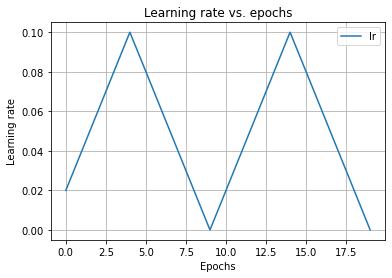

test acc: {'accuracy': 0.5192}
len(layers) = 17
model summary: 
layer 0: dense: 
	 shape -- in: 3072, out: 50
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2)
	 activation: relu

layer 1: batch norm with momentum 0.9
layer 2: dense: 
	 shape -- in: 50, out: 30
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2)
	 activation: relu

layer 3: batch norm with momentum 0.9
layer 4: dense: 
	 shape -- in: 30, out: 20
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2)
	 activation: relu

layer 5: batch norm with momentum 0.9
layer 6: dense: 
	 shape -- in: 20, out: 20
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.001000^2)
	 activation: relu

layer 7:

batch 450/450: 100%|██████████| 450/450 [00:07<00:00, 58.85it/s]
epoch 20/20 
 	 -- train loss = 1.19410053414125 / train cost = 1.3133224192243609
	 -- {"accuracy_train": 0.5757555555555556} 
	 -- val loss = 1.4316822055820688 / val cost = 1.5509040906651796
	 -- {"accuracy_val": 0.4922} 




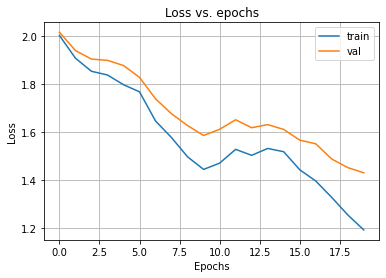

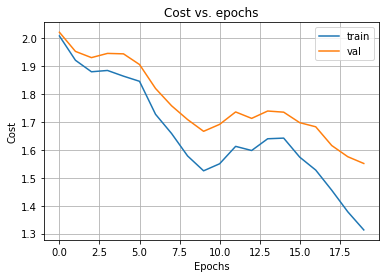

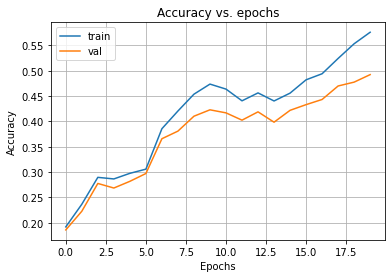

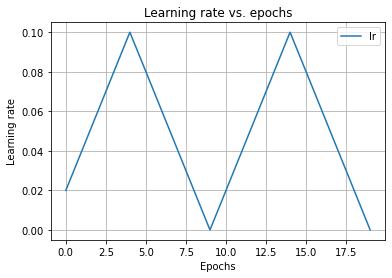

test acc: {'accuracy': 0.5079}
len(layers) = 17
model summary: 
layer 0: dense: 
	 shape -- in: 3072, out: 50
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2)
	 activation: relu

layer 1: batch norm with momentum 0.9
layer 2: dense: 
	 shape -- in: 50, out: 30
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2)
	 activation: relu

layer 3: batch norm with momentum 0.9
layer 4: dense: 
	 shape -- in: 30, out: 20
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2)
	 activation: relu

layer 5: batch norm with momentum 0.9
layer 6: dense: 
	 shape -- in: 20, out: 20
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2), reg: l2 with 5.0000e-03
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.000100^2)
	 activation: relu

layer 7:

batch 450/450: 100%|██████████| 450/450 [00:06<00:00, 68.74it/s]
epoch 20/20 
 	 -- train loss = 2.3025867548022463 / train cost = 2.3025867981889787
	 -- {"accuracy_train": 0.09993333333333333} 
	 -- val loss = 2.3026428525557123 / val cost = 2.3026428959424448
	 -- {"accuracy_val": 0.1006} 




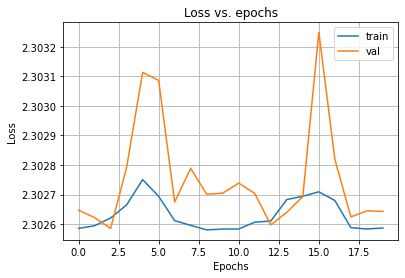

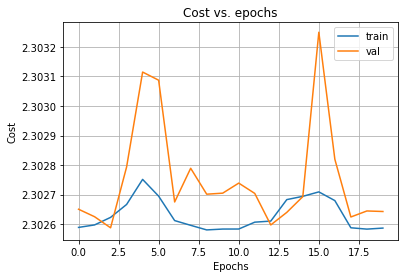

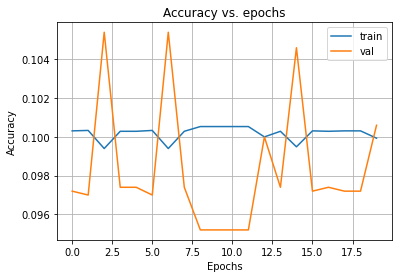

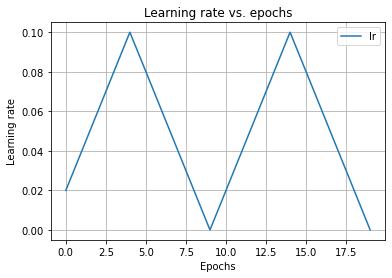

test acc: {'accuracy': 0.1}
    n_layers  if_bn   sigma  test_accuracy
0          3  False  0.1000         0.5346
1          3  False  0.0010         0.5193
2          3  False  0.0001         0.1000
3          3   True  0.1000         0.5360
4          3   True  0.0010         0.5346
5          3   True  0.0001         0.5350
6          9  False  0.1000         0.1000
7          9  False  0.0010         0.1000
8          9  False  0.0001         0.1000
9          9   True  0.1000         0.5192
10         9   True  0.0010         0.5079
11         9   True  0.0001         0.1000


In [15]:
in_dim = x_train.shape[1]
out_dim = 10

dims_3 = [50, 50]
dims_3 = list(reversed(list(reversed(dims_3)) + [in_dim])) + [out_dim]

dims_9 = [50, 30, 20, 20, 10, 10, 10, 10]
dims_9 = list(reversed(list(reversed(dims_9)) + [in_dim])) + [out_dim]

dims_all = [dims_3, dims_9]

batch_size = 100
n_epochs = 20

sigmas = [1e-1, 1e-3, 1e-4]

results_dict = {"n_layers": [], "if_bn": [], "sigma": [], "test_accuracy": []}

if_bns = [False, True]

for dims in dims_all:
    
    for if_bn in if_bns:

        for sigma in sigmas:

            model = network_bn_sigma(dims, if_bn, sigma)

            history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)

            params_test = {"mode": "test"}
            scores_test = model.forward(x_test, **params_test)
            y_hat_test = np.argmax(scores_test, axis=1)
            metrics_test = model.compute_metrics(y_test, scores_test)

            filename = f"{len(dims)-1}_layer_{'with' if if_bn else 'no'}_bn_normal_init_sigma_{sigma}"
            plot_losses(history, filename)
            plot_costs(history, filename)
            plot_accuracies(history, filename)
            plot_lr(history, filename)

            print(f"test acc: {metrics_test}")

            results_dict["n_layers"].append(len(dims)-1)
            results_dict["if_bn"].append(if_bn)
            results_dict["sigma"].append(sigma)
            results_dict["test_accuracy"].append(metrics_test["accuracy"])

# df from list of dicts of params and objective val
results_df = pd.DataFrame(data=results_dict)

# save to csv
path = os.path.join("sensitivity_to_init.csv")
results_df.to_csv(path, encoding='utf-8', index=False)
print(results_df)